In [415]:
# importing needed library 
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.metrics import roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model


**I used the given dataset.**

In [416]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load our given dataset here
#if you want to use other data just give the correct path
data = pd.read_csv('/home/ali/datamining/clinical_notes.csv')

#lets see what is going on in our data
print(data.head(20))
print(data.info())


      age  gender   race     ethnicity language         maritalstatus  \
0   56.56  female  black  non-hispanic  english                single   
1   53.91  female  white  non-hispanic  english                single   
2   46.30  female  white  non-hispanic  english                single   
3   66.52    male  white  non-hispanic  english                single   
4   82.52  female  black  non-hispanic  english              divorced   
5   41.79  female  white       unknown  english  married or partnered   
6   43.80    male  white  non-hispanic  english  married or partnered   
7   70.21    male  white  non-hispanic  english                single   
8   86.58  female  white  non-hispanic  english               widowed   
9   29.89  female  white  non-hispanic  english                single   
10  64.55    male  white  non-hispanic  english  married or partnered   
11  57.99    male  white  non-hispanic  english  married or partnered   
12  64.24    male  white  non-hispanic  english  ma

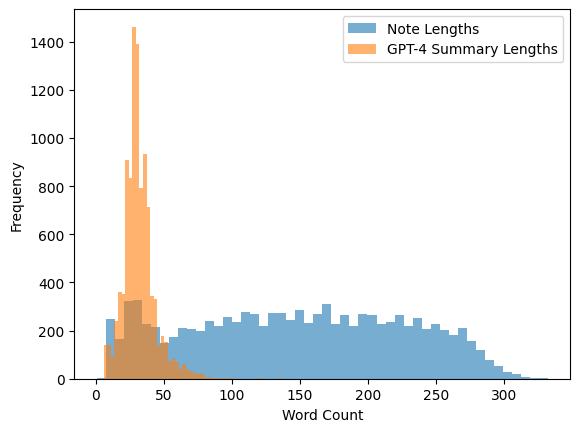

In [417]:
#some statistic to define a good max length

note_lengths = data['note'].astype(str).apply(lambda x: len(x.split()))
summary_lengths = data['gpt4_summary'].astype(str).apply(lambda x: len(x.split()))

plt.hist(note_lengths, bins=50, alpha=0.6, label='Note Lengths')
plt.hist(summary_lengths, bins=50, alpha=0.6, label='GPT-4 Summary Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [418]:
data['note'] = data['note'].fillna('')

# split our dataset in to three set of data traing set, validation set, and test set

train_data = data[data['use'] == 'training']
val_data = data[data['use'] == 'validation']
test_data = data[data['use'] == 'test']

#we have two columns that are text based columns: we have to use tokenizer to crate a vectors for each text cell

text_data = pd.concat([train_data['note'], train_data['gpt4_summary'],
                       val_data['note'], val_data['gpt4_summary'],
                       test_data['note'], test_data['gpt4_summary']])

# now we define of tokenizer:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(text_data)

max_length = 100

# start preprocessing for our text_based data
def Text_preprocessing(data, tokenizer, max_length):
    notes_seq = pad_sequences(tokenizer.texts_to_sequences(data['note']), maxlen=max_length, padding='post')
    summaries_seq = pad_sequences(tokenizer.texts_to_sequences(data['gpt4_summary']), maxlen=max_length, padding='post')
    return notes_seq, summaries_seq

X_train_note, X_train_summary = Text_preprocessing(train_data, tokenizer, max_length)
X_val_note, X_val_summary = Text_preprocessing(val_data, tokenizer, max_length)
X_test_note, X_test_summary = Text_preprocessing(test_data, tokenizer, max_length)

In [419]:
#lets see our texts are tokenized correctly or not!

print("train:")
X_train_note[0]

train:


array([  42, 5357,  965, 7813,    4,   24,    1, 1837,   18,  112,  185,
         17,   38,   69,   64,  420,  424,   10,  347,  524,   19,  164,
        388,   16,  451,  769,    4, 1003,    8,   79,  258,   67,    7,
          6,   15,  192,    6,  406,  148,    5,  656,  864,  116,    5,
         53,  116,    5,   12,  238,   14,  384,   79,   40,  197,   77,
        183,  313,   13,  119,    4,  544,  119,   18, 1712,   88,  316,
        558,    9, 2398,   43,  292,    4,  266,   30,   15,    4,   67,
          6,  291,   36,  413,    7,    6,  208,  268,   43,   83,  202,
          6,  208,  495,  285,    4,  378,  153,  372,  161,    9,  190,
       2275], dtype=int32)

In [420]:
print("val:")
X_val_note[0]


val:


array([  49,  594,   48,   42,   82,   82,    4,   82,  256,    3,    2,
        168,  139,  178,  883,   28,   26,   71,   50,  723,  206,    3,
          2, 7005,  103,   23,   12,  226,  402,  452,  455,    4,  249,
         38,   69,   48,   28,   26,   75, 1477,  115,   16,   75,    1,
        766,    3,    2,   10,   75, 1160,  115,   10,  154,    8,  330,
          3,    2,   14,  402,  452,  455,   28,   26,   43,    9,  492,
        813,   36,  181,   14, 1789,    9,   14,   15,    9,   17,    3,
          2,    9,   43,   31,  186,  289,   30,  187,   31,  338,    4,
        326,   54,    6,  149,  369,   29,  166,  181,   21,  259,    4,
        346], dtype=int32)

In [421]:

print("test:")
X_test_note[0]

test:


array([  93,  349,  185,  154,   13,    3,    2,   14,   32,  218,   35,
         16,  164,   22,  107,   67,   39, 2554,    3,    2,  150,  488,
         44,    3,    2,    7,   18,  342,  304,   40, 1752,   95,  272,
        361,   10,  104,  604,  824,    5,  337,   97,   13,    3,    2,
         29, 7460, 3102,  693,   92,  346,  171,  573,   88, 5639,   37,
        824, 4127, 2440,  231, 1235, 1304,    3, 3244,  105,   97,    3,
          2, 3244,  105,   34,    3,    2, 3244,  105,   35,    3,    2,
       3016,  359,   10,  360,   10,   57,    5,  767,   38, 1542,   10,
        154,   13,    3,    2,   14,   32,  218,   35,   16,  164,   22,
        107], dtype=int32)

In [422]:
X_train_summary[0]

array([   6, 1233,   70,   51,  101,   15,   25,   41,   47,  515,  477,
          4,  420,  424,   13,   28,   26,    4,   20,   33,    5, 5357,
        965, 4423,   18,  281,    5,   11,  446,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [423]:
train_data.head(20)

,age,gender,race,ethnicity,language,maritalstatus,note,gpt4_summary,glaucoma,use
0,56.56,female,black,non-hispanic,english,single,ms. PERSON is a 56 yo woman presenting to esta...,The 56 y/o female patient has optic nerve head...,yes,training
1,53.91,female,white,non-hispanic,english,single,referred for evaluation of narrow angles ou #p...,Patient was referred for narrow angle evaluati...,yes,training
2,46.30,female,white,non-hispanic,english,single,1. left upper lid ptosis: occurred after botox...,"Patient experienced ptosis, ear and eye pain, ...",no,training
3,66.52,male,white,non-hispanic,english,single,right plano +0.50 082 left LOCATION -0.50 83 a...,The patient has primary open angle glaucoma - ...,yes,training
4,82.52,female,black,non-hispanic,english,divorced,in step. os with nonspecific peripheral defect...,The patient has nonspecific peripheral defects...,yes,training
5,41.79,female,white,unknown,english,married or partnered,formulation: this patient presents for follow ...,Patient has optic nerve head drusen with no vi...,yes,training
6,43.80,male,white,non-hispanic,english,married or partnered,without loss of consciousness. since then he p...,Patient reports worsened vision and right peri...,yes,training
7,70.21,male,white,non-hispanic,english,single,DATE_TIME. m referred by dr. PERSON for glauco...,The patient was referred for glaucoma and cata...,yes,training
8,86.58,female,white,non-hispanic,english,widowed,right eye: superior > inferior thinning retina...,"The patient, an 86 y.o. female, has primary op...",yes,training
9,29.89,female,white,non-hispanic,english,single,the exam DATE_TIME showed significant improvem...,Patient showed significant improvement in left...,yes,training


In [424]:
print(train_data['glaucoma'].unique())


['yes' 'no']


In [425]:
# we have to take care of "glaucoma" column, we have to change str to binary 


train_data['glaucoma'] = train_data['glaucoma'].str.strip().str.lower()
val_data['glaucoma'] = val_data['glaucoma'].str.strip().str.lower()
test_data['glaucoma'] = test_data['glaucoma'].str.strip().str.lower()

train_data['glaucoma'] = train_data['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)
val_data['glaucoma'] = val_data['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)
test_data['glaucoma'] = test_data['glaucoma'].apply(lambda x: 1 if x == 'yes' else 0)



/tmp/ipykernel_669949/3183171883.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['glaucoma'] = train_data['glaucoma'].str.strip().str.lower()
/tmp/ipykernel_669949/3183171883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['glaucoma'] = val_data['glaucoma'].str.strip().str.lower()
/tmp/ipykernel_669949/3183171883.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [426]:
print(train_data['glaucoma'].unique())
print(val_data['glaucoma'].unique())
print(test_data['glaucoma'].unique())


[1 0]
[0 1]
[0 1]


In [427]:
#yes! the data is ready for training the model
train_data.head(20)

,age,gender,race,ethnicity,language,maritalstatus,note,gpt4_summary,glaucoma,use
0,56.56,female,black,non-hispanic,english,single,ms. PERSON is a 56 yo woman presenting to esta...,The 56 y/o female patient has optic nerve head...,1,training
1,53.91,female,white,non-hispanic,english,single,referred for evaluation of narrow angles ou #p...,Patient was referred for narrow angle evaluati...,1,training
2,46.30,female,white,non-hispanic,english,single,1. left upper lid ptosis: occurred after botox...,"Patient experienced ptosis, ear and eye pain, ...",0,training
3,66.52,male,white,non-hispanic,english,single,right plano +0.50 082 left LOCATION -0.50 83 a...,The patient has primary open angle glaucoma - ...,1,training
4,82.52,female,black,non-hispanic,english,divorced,in step. os with nonspecific peripheral defect...,The patient has nonspecific peripheral defects...,1,training
5,41.79,female,white,unknown,english,married or partnered,formulation: this patient presents for follow ...,Patient has optic nerve head drusen with no vi...,1,training
6,43.80,male,white,non-hispanic,english,married or partnered,without loss of consciousness. since then he p...,Patient reports worsened vision and right peri...,1,training
7,70.21,male,white,non-hispanic,english,single,DATE_TIME. m referred by dr. PERSON for glauco...,The patient was referred for glaucoma and cata...,1,training
8,86.58,female,white,non-hispanic,english,widowed,right eye: superior > inferior thinning retina...,"The patient, an 86 y.o. female, has primary op...",1,training
9,29.89,female,white,non-hispanic,english,single,the exam DATE_TIME showed significant improvem...,Patient showed significant improvement in left...,1,training


In [428]:
train_data['glaucoma'][0]

1

**for now it is the best model: we have two layer LSTM, with l1 l2 regularization **:

In [153]:
from keras.layers import LayerNormalization, Embedding, Dropout, LSTM, Dense, Input, BatchNormalization
from keras.models import Model
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

def create_lstm_model(input_length, embedding_dim):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=input_length)(inputs)
    
    # First LSTM layer with L1 and L2 regularization and Batch Normalization
    x = LSTM(32, return_sequences=True, kernel_regularizer=l1_l2(l1=0.002, l2=0.002), recurrent_dropout=0.3)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Second LSTM layer with regularization
    x = LSTM(16, kernel_regularizer=l1_l2(l1=0.002, l2=0.002), recurrent_dropout=0.3)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Final output layer with increased regularization
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0002, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

lstm_model = create_lstm_model(input_length=X_train_note.shape[1], embedding_dim=100)




In [154]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_data['glaucoma']), y=train_data['glaucoma'])
class_weights_dict = dict(enumerate(class_weights))

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005)

# Train the model with class weights
hist = lstm_model.fit(
    X_train_note, train_data['glaucoma'],
    validation_data=(X_val_note, val_data['glaucoma']),
    epochs=40,
    batch_size=16,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
438/438 [==============================] - 103s 236ms/step - loss: 2.8273 - accuracy: 0.5333 - auc: 0.5431 - val_loss: 1.9703 - val_accuracy: 0.5730 - val_auc: 0.6234 - lr: 2.0000e-04
Epoch 2/40
438/438 [==============================] - 99s 226ms/step - loss: 1.7189 - accuracy: 0.5683 - auc: 0.5896 - val_loss: 1.4813 - val_accuracy: 0.5940 - val_auc: 0.6359 - lr: 2.0000e-04
Epoch 3/40
438/438 [==============================] - 100s 228ms/step - loss: 1.4474 - accuracy: 0.5846 - auc: 0.6223 - val_loss: 1.3404 - val_accuracy: 0.5590 - val_auc: 0.6327 - lr: 2.0000e-04
Epoch 4/40
438/438 [==============================] - 99s 225ms/step - loss: 1.2489 - accuracy: 0.6393 - auc: 0.7009 - val_loss: 1.2556 - val_accuracy: 0.5890 - val_auc: 0.6904 - lr: 2.0000e-04
Epoch 5/40
438/438 [==============================] - 99s 226ms/step - loss: 1.0642 - accuracy: 0.7206 - auc: 0.7919 - val_loss: 1.0878 - val_accuracy: 0.6770 - val_auc: 0.7793 - lr: 2.0000e-04
Epoch 6/40
438/438 [========

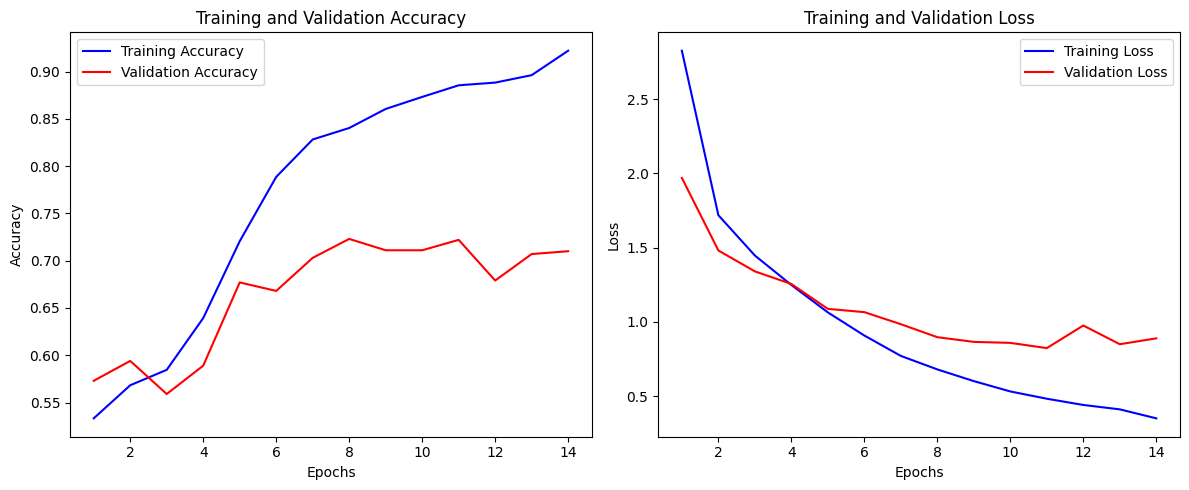

In [155]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the accuracy and loss for both training and validation datasets.

    Parameters:
    history: History object returned by the model's fit() function.
    """
    # Extract accuracy and loss values for training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'hist' is the History object returned by model.fit()
plot_training_history(hist)

In [156]:
# define a function to calculate Overall AUC using our Test set

import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_auc_by_race(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    overall_predictions = np.ravel(model.predict(X_test))
    overall_auc = roc_auc_score(test_data[target_column], overall_predictions)


    race_aucs = {}
    for race in [0, 1, 2]:  # Asian = 0, Black = 1, White = 2
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:
            race_predictions = overall_predictions[race_indices]
            race_true_labels = test_data.loc[race_indices, target_column]
            race_auc = roc_auc_score(race_true_labels, race_predictions)
            race_aucs[race] = race_auc
        else:
            race_aucs[race] = None

    return overall_auc, race_aucs


overall_auc, race_aucs = calculate_auc_by_race(lstm_model, X_test_note, test_data)
print("Overall AUC:", overall_auc)
print("AUCs by Race:", race_aucs)

Overall AUC: 0.7927053411254554
AUCs by Race: {0: None, 1: None, 2: None}


In [157]:
# then we define a function to calculate AUCs by Races we have in our dataset

def calculate_auc_by_race(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    test_data.reset_index(drop=True, inplace=True)


    overall_predictions = np.ravel(model.predict(X_test))


    print("Overall Predictions Shape:", overall_predictions.shape)
    print("Test Data Shape:", test_data.shape)

    overall_auc = roc_auc_score(test_data[target_column], overall_predictions)


    race_aucs = {}
    race_labels = ['white', 'asian', 'black']

    for race in race_labels:
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:

            race_predictions = overall_predictions[race_indices.to_list()]
            race_true_labels = test_data.loc[race_indices, target_column]
            race_auc = roc_auc_score(race_true_labels, race_predictions)
            race_aucs[race] = race_auc
        else:
            race_aucs[race] = None

    return overall_auc, race_aucs

overall_auc, race_aucs = calculate_auc_by_race(lstm_model, X_test_note, test_data)
print("Overall AUC:", overall_auc)
print("AUCs by Race:", race_aucs)


Overall Predictions Shape: (2000,)
Test Data Shape: (2000, 10)
Overall AUC: 0.7927053411254554
AUCs by Race: {'white': 0.7822219624109581, 'asian': 0.8676494151578272, 'black': 0.8106627972289833}


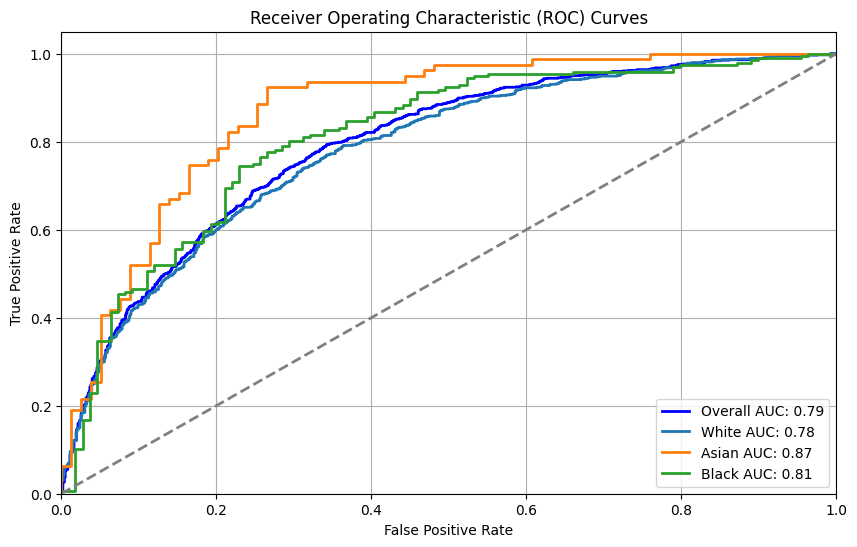

In [158]:
# now we compare overall AUC with AUCs by Races we have in our dataset

from sklearn.metrics import roc_curve, auc

def plot_roc_curves(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    overall_predictions = np.ravel(model.predict(X_test))


    plt.figure(figsize=(10, 6))


    fpr, tpr, _ = roc_curve(test_data[target_column], overall_predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label='Overall AUC: {:.2f}'.format(roc_auc))


    race_labels = ['white', 'asian', 'black']
    for race in race_labels:
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:
            race_predictions = overall_predictions[race_indices]
            race_true_labels = test_data.loc[race_indices, target_column]
            fpr, tpr, _ = roc_curve(race_true_labels, race_predictions)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='{} AUC: {:.2f}'.format(race.capitalize(), roc_auc))

    # Plotting settings
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


plot_roc_curves(lstm_model, X_test_note, test_data)


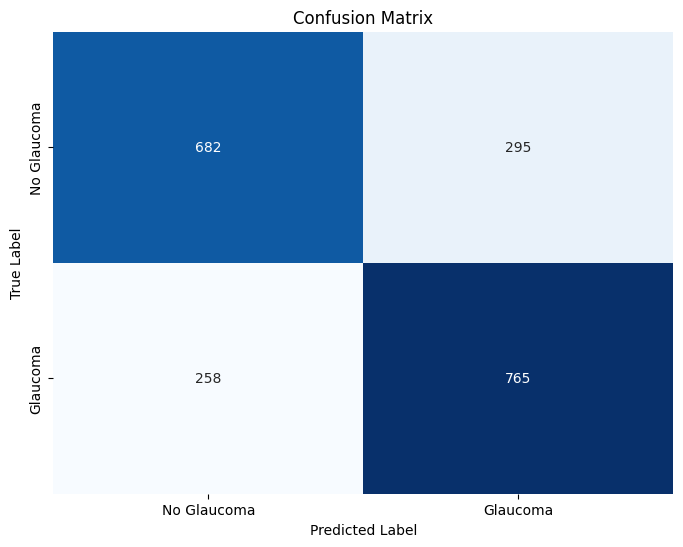

In [159]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, test_data, target_column='glaucoma'):

    predictions_prob = model.predict(X_test)
    predictions = (predictions_prob > 0.5).astype(int)


    cm = confusion_matrix(test_data[target_column], predictions)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Glaucoma', 'Glaucoma'],
                yticklabels=['No Glaucoma', 'Glaucoma'])


    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(lstm_model, X_test_note, test_data)


#default CNN Model:
******************************************************************************************************************************************************************

In [237]:
# define our benchmarks
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Input, Embedding, BatchNormalization, GlobalMaxPooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


embedding_dim = 64
def create_cnn_model(input_length, embedding_dim):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=input_length)(inputs)
    
    # First Conv1D layer with BatchNormalization, L1 and L2 regularization, and Dropout
    x = Conv1D(64, 5, activation='relu', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.6)(x)  # Increased Dropout rate

    # Second Conv1D layer with BatchNormalization, L1 and L2 regularization, and Dropout
    x = Conv1D(32, 5, activation='relu', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.6)(x)  # Increased Dropout rate

    # Global Max Pooling
    x = GlobalMaxPooling1D()(x)

    # Fully connected layer with L1 and L2 regularization and Dropout
    x = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)
    x = Dropout(0.6)(x)
    
    # Output layer with L1 and L2 regularization
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

# Create and summarize the CNN model
cnn_model = create_cnn_model(input_length=max_length, embedding_dim=embedding_dim)
cnn_model.summary()

# Early stopping and learning rate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  # More aggressive patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005)

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_51 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 96, 64)            20544     
_________________________________________________________________
batch_normalization_9 (Batch (None, 96, 64)            256       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 48, 64)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 44, 32)            102

In [238]:
# CNN model

hist = cnn_model.fit(
    X_train_note, train_data['glaucoma'],
    validation_data=(X_val_note, val_data['glaucoma']),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
219/219 [==============================] - 3s 15ms/step - loss: 4.9793 - accuracy: 0.4957 - auc: 0.5010 - val_loss: 4.2083 - val_accuracy: 0.5370 - val_auc: 0.5452 - lr: 5.0000e-04
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 4.0927 - accuracy: 0.5024 - auc: 0.5123 - val_loss: 3.8880 - val_accuracy: 0.5520 - val_auc: 0.5865 - lr: 5.0000e-04
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 3.7249 - accuracy: 0.5006 - auc: 0.5075 - val_loss: 3.5107 - val_accuracy: 0.5330 - val_auc: 0.5723 - lr: 5.0000e-04
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 3.3187 - accuracy: 0.5074 - auc: 0.5096 - val_loss: 3.0897 - val_accuracy: 0.5380 - val_auc: 0.5907 - lr: 5.0000e-04
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 2.8841 - accuracy: 0.5189 - auc: 0.5190 - val_loss: 2.6517 - val_accuracy: 0.5340 - val_auc: 0.5779 - lr: 5.0000e-04
Epoch 6/20
219/219 [====================

In [240]:

# define a function to calculate Overall AUC using our Test set

import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_auc_by_race(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    overall_predictions = np.ravel(model.predict(X_test))
    overall_auc = roc_auc_score(test_data[target_column], overall_predictions)


    race_aucs = {}
    for race in [0, 1, 2]:  # Asian = 0, Black = 1, White = 2
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:
            race_predictions = overall_predictions[race_indices]
            race_true_labels = test_data.loc[race_indices, target_column]
            race_auc = roc_auc_score(race_true_labels, race_predictions)
            race_aucs[race] = race_auc
        else:
            race_aucs[race] = None

    return overall_auc, race_aucs


overall_auc, race_aucs = calculate_auc_by_race(cnn_model, X_test_note, test_data)
print("Overall AUC:", overall_auc)
print("AUCs by Race:", race_aucs)


Overall AUC: 0.7987695490914692
AUCs by Race: {0: None, 1: None, 2: None}


In [241]:
# then we define a function to calculate AUCs by Races we have in our dataset

def calculate_auc_by_race(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    test_data.reset_index(drop=True, inplace=True)


    overall_predictions = np.ravel(model.predict(X_test))


    print("Overall Predictions Shape:", overall_predictions.shape)
    print("Test Data Shape:", test_data.shape)

    overall_auc = roc_auc_score(test_data[target_column], overall_predictions)


    race_aucs = {}
    race_labels = ['white', 'asian', 'black']

    for race in race_labels:
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:

            race_predictions = overall_predictions[race_indices.to_list()]
            race_true_labels = test_data.loc[race_indices, target_column]
            race_auc = roc_auc_score(race_true_labels, race_predictions)
            race_aucs[race] = race_auc
        else:
            race_aucs[race] = None

    return overall_auc, race_aucs

overall_auc, race_aucs = calculate_auc_by_race(cnn_model, X_test_note, test_data)
print("Overall AUC:", overall_auc)
print("AUCs by Race:", race_aucs)


Overall Predictions Shape: (2000,)
Test Data Shape: (2000, 10)
Overall AUC: 0.7987695490914692
AUCs by Race: {'white': 0.7875136400913633, 'asian': 0.8614004165999039, 'black': 0.8266242276727205}


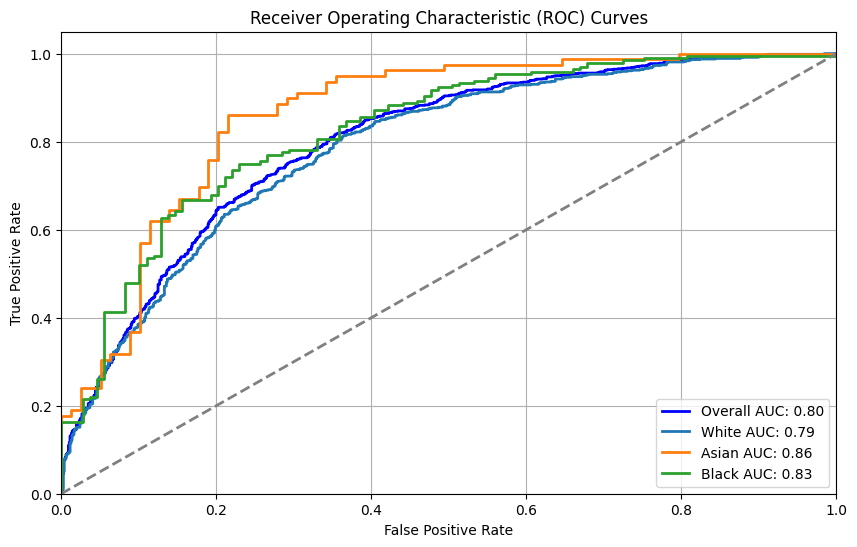

In [242]:
# now we compare overall AUC with AUCs by Races we have in our dataset

from sklearn.metrics import roc_curve, auc

def plot_roc_curves(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    overall_predictions = np.ravel(model.predict(X_test))


    plt.figure(figsize=(10, 6))


    fpr, tpr, _ = roc_curve(test_data[target_column], overall_predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label='Overall AUC: {:.2f}'.format(roc_auc))


    race_labels = ['white', 'asian', 'black']
    for race in race_labels:
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:
            race_predictions = overall_predictions[race_indices]
            race_true_labels = test_data.loc[race_indices, target_column]
            fpr, tpr, _ = roc_curve(race_true_labels, race_predictions)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='{} AUC: {:.2f}'.format(race.capitalize(), roc_auc))

    # Plotting settings
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


plot_roc_curves(cnn_model, X_test_note, test_data)


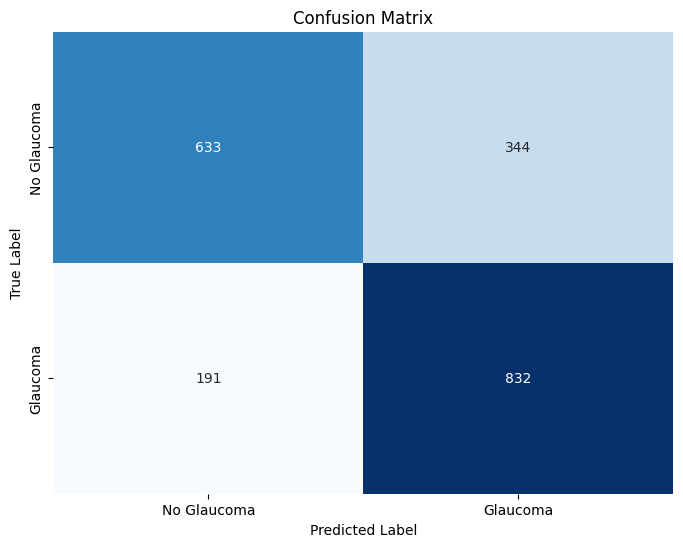

In [243]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, test_data, target_column='glaucoma'):

    predictions_prob = model.predict(X_test)
    predictions = (predictions_prob > 0.5).astype(int)


    cm = confusion_matrix(test_data[target_column], predictions)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Glaucoma', 'Glaucoma'],
                yticklabels=['No Glaucoma', 'Glaucoma'])


    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(cnn_model, X_test_note, test_data)


another CNN model

In [253]:
from keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Input, Embedding, BatchNormalization, GlobalMaxPooling1D
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from keras.optimizers import Adam
from keras.regularizers import l1_l2

embedding_dim = 64

# Updated CNN Model with Stronger L1 and L2 Regularization and Increased Dropout
def create_cnn_model(input_length, embedding_dim):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=input_length)(inputs)
    
    # First Conv1D layer with BatchNormalization, L1 and L2 regularization, and Dropout
    x = Conv1D(64, 5, activation='relu', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.6)(x)  # Increased Dropout rate

    # Second Conv1D layer with BatchNormalization, L1 and L2 regularization, and Dropout
    x = Conv1D(32, 5, activation='relu', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.6)(x)

    # Global Max Pooling
    x = GlobalMaxPooling1D()(x)

    # Fully connected layer with L1 and L2 regularization and Dropout
    x = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)
    x = Dropout(0.6)(x)
    
    # Output layer with L1 and L2 regularization
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=0.002, l2=0.002))(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

# Create and summarize the CNN model
cnn_model = create_cnn_model(input_length=max_length, embedding_dim=embedding_dim)
cnn_model.summary()

# Early stopping, learning rate reduction, and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005)
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')



Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_53 (Embedding)     (None, 100, 64)           640000    
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 96, 64)            20544     
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 64)            256       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 48, 64)            0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 48, 64)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 44, 32)            102

In [254]:
hist = cnn_model.fit(
    X_train_note, train_data['glaucoma'],
    validation_data=(X_val_note, val_data['glaucoma']),
    epochs=25,  # Increase epochs if needed, and watch for early stopping
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/25
219/219 [==============================] - 3s 15ms/step - loss: 5.7076 - accuracy: 0.5097 - auc: 0.5049 - val_loss: 4.2050 - val_accuracy: 0.4900 - val_auc: 0.5222 - lr: 5.0000e-04
Epoch 2/25
219/219 [==============================] - 3s 13ms/step - loss: 4.1225 - accuracy: 0.5147 - auc: 0.5311 - val_loss: 3.9143 - val_accuracy: 0.4900 - val_auc: 0.5406 - lr: 5.0000e-04
Epoch 3/25
219/219 [==============================] - 3s 13ms/step - loss: 3.7511 - accuracy: 0.5257 - auc: 0.5408 - val_loss: 3.5588 - val_accuracy: 0.5620 - val_auc: 0.6058 - lr: 5.0000e-04
Epoch 4/25
219/219 [==============================] - 3s 13ms/step - loss: 3.3753 - accuracy: 0.5420 - auc: 0.5691 - val_loss: 3.1736 - val_accuracy: 0.5680 - val_auc: 0.6456 - lr: 5.0000e-04
Epoch 5/25
219/219 [==============================] - 3s 13ms/step - loss: 2.9844 - accuracy: 0.5379 - auc: 0.5686 - val_loss: 2.7735 - val_accuracy: 0.5960 - val_auc: 0.6481 - lr: 5.0000e-04
Epoch 6/25
219/219 [====================

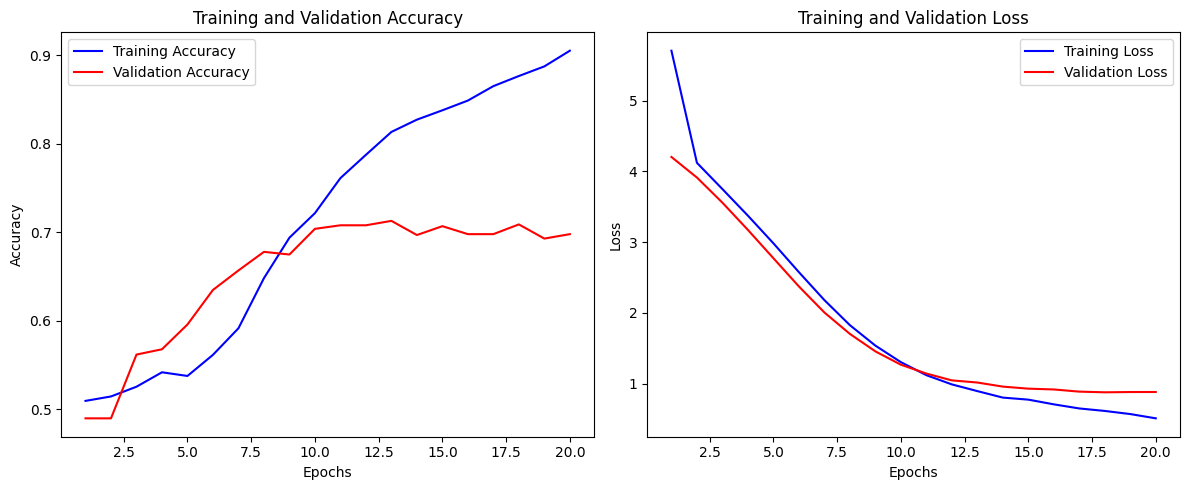

In [255]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the accuracy and loss for both training and validation datasets.

    Parameters:
    history: History object returned by the model's fit() function.
    """
    # Extract accuracy and loss values for training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'hist' is the History object returned by model.fit()
plot_training_history(hist)

In [256]:
# define a function to calculate Overall AUC using our Test set

import numpy as np
from sklearn.metrics import roc_auc_score

def calculate_auc_by_race(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    overall_predictions = np.ravel(model.predict(X_test))
    overall_auc = roc_auc_score(test_data[target_column], overall_predictions)


    race_aucs = {}
    for race in [0, 1, 2]:  # Asian = 0, Black = 1, White = 2
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:
            race_predictions = overall_predictions[race_indices]
            race_true_labels = test_data.loc[race_indices, target_column]
            race_auc = roc_auc_score(race_true_labels, race_predictions)
            race_aucs[race] = race_auc
        else:
            race_aucs[race] = None

    return overall_auc, race_aucs


overall_auc, race_aucs = calculate_auc_by_race(cnn_model, X_test_note, test_data)
print("Overall AUC:", overall_auc)
print("AUCs by Race:", race_aucs)

Overall AUC: 0.7951331254233489
AUCs by Race: {0: None, 1: None, 2: None}


In [257]:
# then we define a function to calculate AUCs by Races we have in our dataset

def calculate_auc_by_race(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    test_data.reset_index(drop=True, inplace=True)


    overall_predictions = np.ravel(model.predict(X_test))


    print("Overall Predictions Shape:", overall_predictions.shape)
    print("Test Data Shape:", test_data.shape)

    overall_auc = roc_auc_score(test_data[target_column], overall_predictions)


    race_aucs = {}
    race_labels = ['white', 'asian', 'black']

    for race in race_labels:
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:

            race_predictions = overall_predictions[race_indices.to_list()]
            race_true_labels = test_data.loc[race_indices, target_column]
            race_auc = roc_auc_score(race_true_labels, race_predictions)
            race_aucs[race] = race_auc
        else:
            race_aucs[race] = None

    return overall_auc, race_aucs

overall_auc, race_aucs = calculate_auc_by_race(cnn_model, X_test_note, test_data)
print("Overall AUC:", overall_auc)
print("AUCs by Race:", race_aucs)

Overall Predictions Shape: (2000,)
Test Data Shape: (2000, 10)
Overall AUC: 0.7951331254233489
AUCs by Race: {'white': 0.7807317188887307, 'asian': 0.8702131068738984, 'black': 0.8301816139299757}


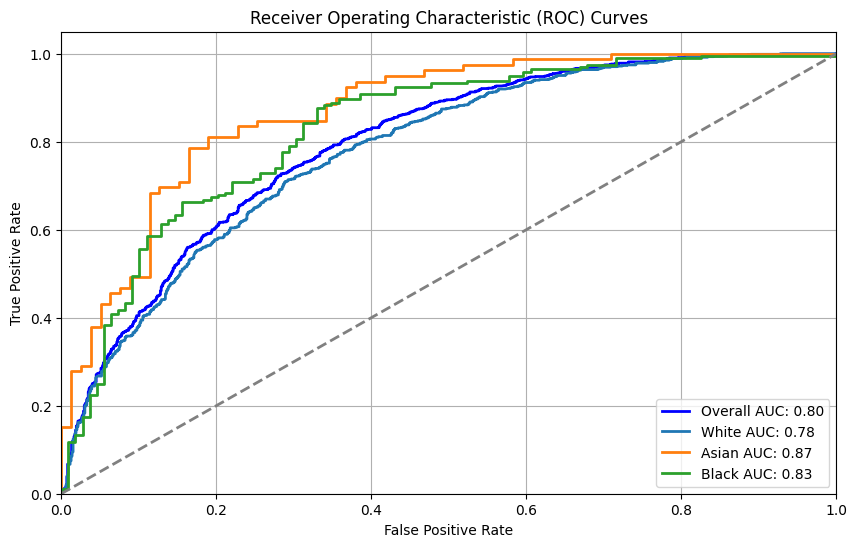

In [258]:
# now we compare overall AUC with AUCs by Races we have in our dataset

from sklearn.metrics import roc_curve, auc

def plot_roc_curves(model, X_test, test_data, race_column='race', target_column='glaucoma'):

    overall_predictions = np.ravel(model.predict(X_test))


    plt.figure(figsize=(10, 6))


    fpr, tpr, _ = roc_curve(test_data[target_column], overall_predictions)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2, label='Overall AUC: {:.2f}'.format(roc_auc))


    race_labels = ['white', 'asian', 'black']
    for race in race_labels:
        race_indices = test_data[test_data[race_column] == race].index
        if len(race_indices) > 0:
            race_predictions = overall_predictions[race_indices]
            race_true_labels = test_data.loc[race_indices, target_column]
            fpr, tpr, _ = roc_curve(race_true_labels, race_predictions)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label='{} AUC: {:.2f}'.format(race.capitalize(), roc_auc))

    # Plotting settings
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


plot_roc_curves(cnn_model, X_test_note, test_data)

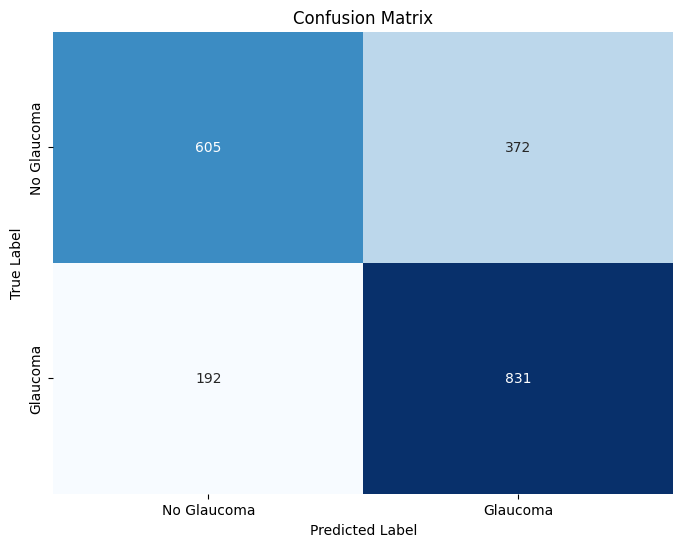

In [259]:
# Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, test_data, target_column='glaucoma'):

    predictions_prob = model.predict(X_test)
    predictions = (predictions_prob > 0.5).astype(int)


    cm = confusion_matrix(test_data[target_column], predictions)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Glaucoma', 'Glaucoma'],
                yticklabels=['No Glaucoma', 'Glaucoma'])


    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(cnn_model, X_test_note, test_data)

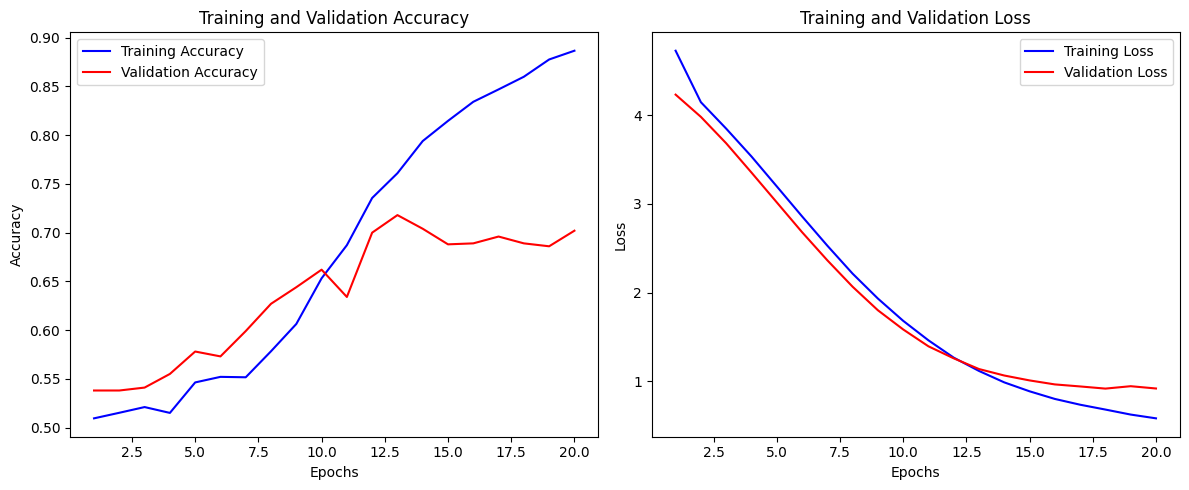

In [431]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the accuracy and loss for both training and validation datasets.

    Parameters:
    history: History object returned by the model's fit() function.
    """
    # Extract accuracy and loss values for training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'hist' is the History object returned by model.fit()
plot_training_history(hist)